In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt



In [45]:
# Read GED_Data and convert geom_wkt points from wkt to geometry
GED_Data = gpd.read_file("../data/ged_data_india.csv")

df= GED_Data[["geom_wkt"]]
df['geom_wkt'] = gpd.GeoSeries.from_wkt(df['geom_wkt'])
gdf = gpd.GeoDataFrame(df, geometry="geom_wkt")

/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_23880/2304819173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geom_wkt'] = gpd.GeoSeries.from_wkt(df['geom_wkt'])


In [52]:
ac = gpd.read_file(r"../data/maps/assembly-constituencies/India_AC.shp")
ac = ac[["Map_ID", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ac, gdf, how='left', op='intersects')
map_id = 'Map_ID'

# Group by assembly constituencies and count the number of points/conflicts
count = sjoin.groupby(map_id)[map_id].count()
count

/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_23880/3817468263.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(AC, gdf, how='left', op='intersects')


Map_ID
1       15
2        3
3        1
4        1
5        2
        ..
4166     1
4167     1
4168     1
4169     1
4170    49
Name: Map_ID, Length: 4169, dtype: int64

<Axes: >

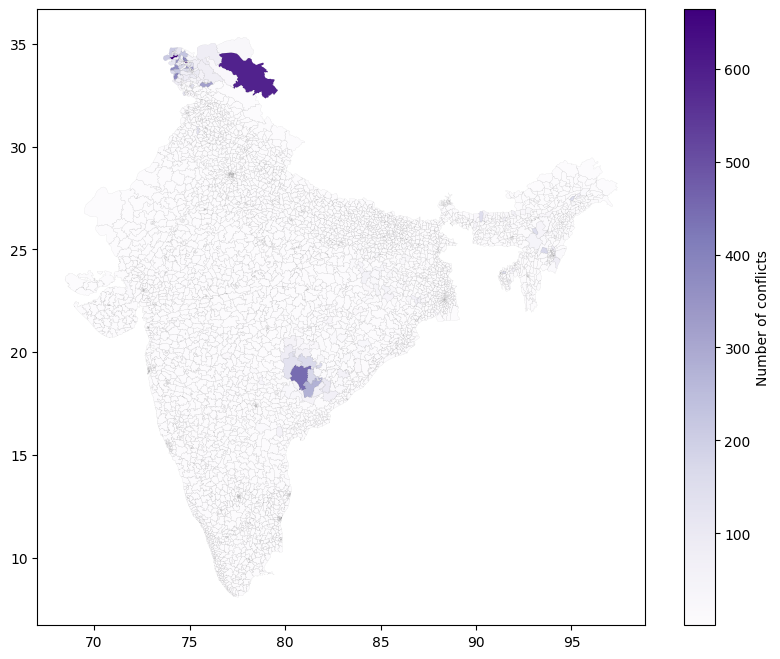

In [54]:
# Choropleth map
count.name='pointcount'
polygons = pd.merge(left=ac, right=count, left_on=map_id, right_index=True)

fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = 'Purples', ax=ax, legend=True, 
              legend_kwds={'label':'Number of conflicts'})
polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)

/Users/christinefang/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/ny/vbk2t6r52hd7yvymd0bn98ww0000gp/T/ipykernel_23880/2718589483.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  sjoin = gpd.sjoin(ab, gdf, how='left', op='intersects')


<Axes: >

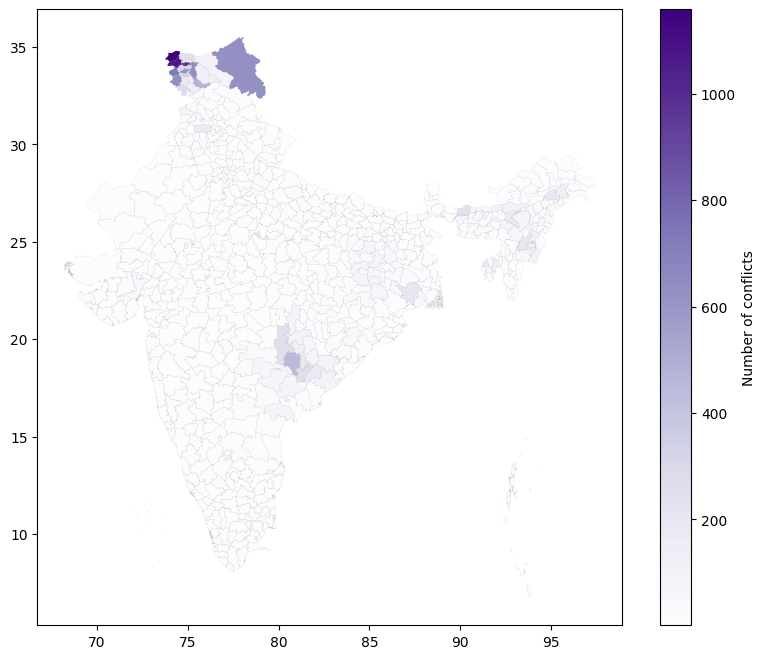

In [71]:
ab = gpd.read_file(r"../data/maps/india administrative boundaries/gadm41_IND_2.shp")
ab = ab[["GID_2", "geometry"]]

# Spatial join AC Polygons and GED_Data Points
sjoin = gpd.sjoin(ab, gdf, how='left', op='intersects')
gid = 'GID_2'

# Group by assembly constituencies and count the number of points/conflicts
count = sjoin.groupby(gid)[gid].count()
count.name='pointcount'
polygons = pd.merge(left=ab, right=count, left_on=gid, right_index=True)

fig, ax = plt.subplots(figsize = (10,8))
polygons.plot(column = 'pointcount', cmap = 'Purples', ax=ax, legend=True, 
              legend_kwds={'label':'Number of conflicts'})
polygons.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.02, ax=ax)